# Linear Regression on KC_Housesales dataset

### Jun 20 2019

In [1]:
# Loading the dependencies 
import pandas as pd
import numpy as np
import math
import tensorflow as tf
from sklearn import metrics
from tensorflow.python.data import Dataset
from matplotlib import gridspec
from matplotlib import cm
from matplotlib import pyplot as plt

In [2]:
tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:,.1f}'.format
# Load the dataset 
kc_data = pd.read_csv("E:/Data Scientist/Datasets/kc_house_data.csv",sep=",")
#kc_data = kc_data.reindex(np.random.permutation(kc_data.index))
# Spliting the dataset into train and test dataset
kc_data_train = pd.DataFrame()
kc_data_test = pd.DataFrame()
kc_data_train = kc_data.head(15000)
kc_data_test = kc_data.tail(6613)
kc_data_train = kc_data_train.reindex(np.random.permutation(kc_data_train.index))
kc_data_test = kc_data_test.reindex(np.random.permutation(kc_data_test.index))

In [3]:
# Preprocess the dataset for features and targets
def preprocess_features(kc_data_train):
    selected_features = kc_data_train[["bedrooms","bathrooms","lat","long","sqft_living"]]
    processed_features = selected_features.copy()
    return processed_features
def preprocess_targets(kc_data_train):
    output_targets = pd.DataFrame()
    output_targets["price"] = (kc_data_train["price"]/1000.0)
    return output_targets

In [4]:
# Loading the dataset for the training data with features
training_features = preprocess_features(kc_data_train.head(10000))
training_features.describe()

,bedrooms,bathrooms,lat,long,sqft_living
count,"10,000.0","10,000.0","10,000.0","10,000.0","10,000.0"
mean,3.3,2.1,47.6,-122.2,"2,043.5"
std,0.9,0.8,0.1,0.1,914.4
min,0.0,0.0,47.2,-122.5,410.0
25%,3.0,1.5,47.5,-122.3,"1,410.0"
50%,3.0,2.0,47.6,-122.2,"1,880.0"
75%,4.0,2.5,47.7,-122.1,"2,480.0"
max,10.0,8.0,47.8,-121.3,"13,540.0"


In [5]:
# Loading the dataset for the training dataset with targets
training_targets = preprocess_targets(kc_data_train.head(10000))
training_targets.describe()

,price
count,"10,000.0"
mean,530.7
std,372.1
min,80.0
25%,315.0
50%,446.0
75%,630.0
max,"7,700.0"


In [6]:
# Loading the validation set from the dataset
validation_features = preprocess_features(kc_data_train.tail(5000))
validation_features.describe()

,bedrooms,bathrooms,lat,long,sqft_living
count,"5,000.0","5,000.0","5,000.0","5,000.0","5,000.0"
mean,3.4,2.1,47.6,-122.2,"2,063.9"
std,0.9,0.8,0.1,0.1,889.0
min,0.0,0.0,47.2,-122.5,380.0
25%,3.0,1.5,47.5,-122.3,"1,410.0"
50%,3.0,2.0,47.6,-122.2,"1,920.0"
75%,4.0,2.5,47.7,-122.1,"2,540.0"
max,11.0,6.0,47.8,-121.3,"7,620.0"


In [7]:
validation_targets = preprocess_targets(kc_data_train.tail(5000))
validation_targets.describe()

,price
count,"5,000.0"
mean,535.8
std,355.1
min,75.0
25%,315.0
50%,448.8
75%,649.0
max,"5,300.0"


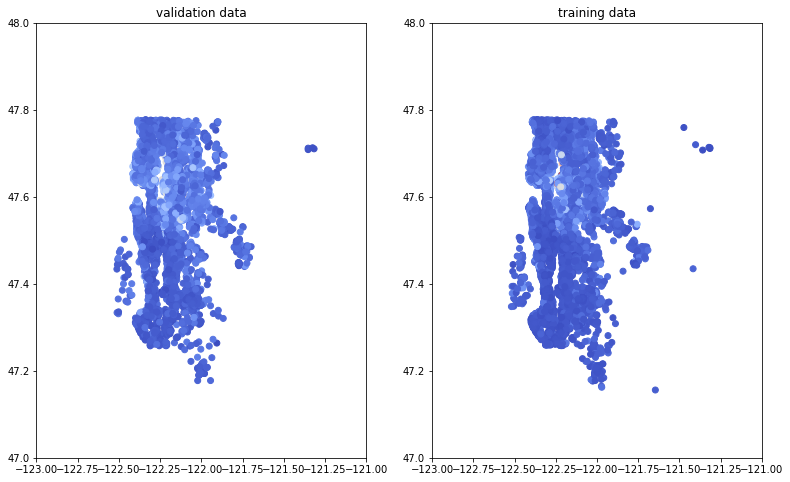

In [8]:
plt.figure(figsize=(13,8))
ax = plt.subplot(1,2,1)
ax.set_title("validation data")
ax.set_autoscaley_on(False)
ax.set_ylim([47,48])
ax.set_autoscalex_on(False)
ax.set_xlim([-123,-121])
plt.scatter(validation_features["long"],validation_features["lat"],cmap ="coolwarm",c=validation_targets["price"]/validation_targets["price"].max())

ax = plt.subplot(1,2,2)
ax.set_title("training data")
ax.set_autoscaley_on(False)
ax.set_ylim([47,48])
ax.set_autoscalex_on(False)
ax.set_xlim([-123,-121])
plt.scatter(training_features["long"],training_features["lat"],cmap="coolwarm", c=training_targets["price"]/training_targets["price"].max())
_=plt.plot()

 From the plot which seen from above most high price house sales happens in the area of (47.2,-122) and (47.6,-121). From the plot we see the area is too dark to represent in the following co-ordinates.

Now we load the features into the tensor flow model by developing the input function where we give the features,targets to the tensors also batch-size and epochs where we dealing the gradient descent

In [9]:
# Defining the input function
def input_func(features,targets,batch_size=1,shuffle=True, num_epochs=None):
    # convert the data into dict using key and value pairs
    features = {key:np.array(value) for key,value in dict(features).items()}
    # Convert the data into dataset using the tensors
    ds = Dataset.from_tensor_slices((features,targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # shuffle the given dataset
    if shuffle:
        ds = ds.shuffle(10000)
    # get the next batch of the dataset
    features,labels = ds.make_one_shot_iterator().get_next()
    return features,labels

In [10]:
def construct_feature_column(input_features):
    return set([tf.feature_column.numeric_column(my_feature)
               for my_feature in input_features])

In [11]:
def train_model(training_features,
                training_targets,
                validation_features,
                validation_targets,
                batch_size,
                learning_rate,
                steps):
    periods = 10
    steps_per_period = steps/periods
    # creating a linear regression object
    linear_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    linear_optimizer = tf.contrib.estimator.clip_gradients_by_norm(linear_optimizer,5.0)
    linear_regressor = tf.estimator.LinearRegressor(feature_columns=construct_feature_column(training_features),optimizer =linear_optimizer )
    # creating input functions 
    training_input_fn = lambda: input_func(training_features,training_targets["price"],batch_size = batch_size)
    predict_training_input = lambda: input_func(training_features,training_targets["price"],num_epochs=1,shuffle=False)
    predict_validation_input = lambda: input_func(validation_features,validation_targets["price"],num_epochs=1,shuffle=False)
    
    # Train the model now
    print("Training the data with linear regressor ------->")
    print("Root Mean Squared error(on training data) ------>")
    training_rmse = []
    validation_rmse=[]
    for period in range(0,periods):
        linear_regressor.train(
        input_fn = training_input_fn,
        steps = steps_per_period,)
        # predicting from the training and validation data
        training_predictions = linear_regressor.predict(input_fn= predict_training_input)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
        validation_predictions = linear_regressor.predict(input_fn = predict_validation_input)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
        # Finding the training and validation loss
        training_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(training_predictions,training_targets))
        validation_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(validation_predictions,validation_targets))
        # printing the loss
        print("period %0.2d : %0.2f" %(period,training_root_mean_squared_error))
        # add the loss metrics from this period to our list
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished")
    # plot the output of the model for understanding
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error Vs periods")
    plt.plot(training_rmse,label = "training")
    plt.plot(validation_rmse,label=" validation")
    plt.legend()
    
    return linear_regressor

Training the data with linear regressor ------->
Root Mean Squared error(on training data) ------>
period 00 : 547.80
period 01 : 453.02
period 02 : 368.11
period 03 : 301.51
period 04 : 270.77
period 05 : 267.35
period 06 : 265.81
period 07 : 265.64
period 08 : 265.57
period 09 : 265.57
Model training finished


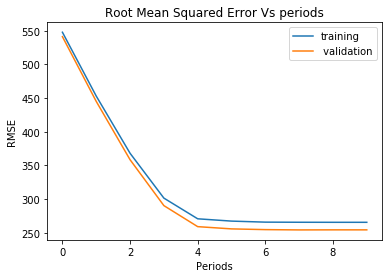

In [71]:
# Now check with your parameters for the linear Regressor
linear_regressor= train_model(learning_rate=0.001,
                              steps = 100,
                              batch_size=20,
                              training_features= training_features,
                              training_targets= training_targets,
                              validation_features=validation_features,
                              validation_targets= validation_targets)

In [35]:
# Now will check the model with the test data
test_features = preprocess_features(kc_data_test)
test_features.describe()

,bedrooms,bathrooms,lat,long,sqft_living
count,"6,613.0","6,613.0","6,613.0","6,613.0","6,613.0"
mean,3.4,2.2,47.6,-122.2,"2,147.1"
std,1.0,0.8,0.1,0.1,942.6
min,0.0,0.0,47.2,-122.5,290.0
25%,3.0,1.8,47.5,-122.3,"1,450.0"
50%,3.0,2.5,47.6,-122.2,"1,960.0"
75%,4.0,2.5,47.7,-122.1,"2,670.0"
max,33.0,6.5,47.8,-121.4,"8,020.0"


In [36]:
test_targets = preprocess_targets(kc_data_test)
test_targets.describe()

,price
count,"6,613.0"
mean,557.5
std,368.0
min,78.0
25%,335.0
50%,464.0
75%,657.0
max,"3,800.0"


In [72]:
# define the input function
predict_test_input = lambda: input_func(test_features,test_targets["price"],num_epochs=1,shuffle=False)
test_predictions = linear_regressor.predict(input_fn = predict_test_input)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])
test_mean_squared_error = math.sqrt(metrics.mean_squared_error(test_predictions,test_targets))
print("Final RMSE (on test data): %0.2f" % test_mean_squared_error)

Final RMSE (on test data): 262.99


In [38]:
kc_data_range = (kc_data['price'].max())-(kc_data['price'].min())
print(kc_data_range)

7625000.0


In [74]:
print("accuracy of the model:",metrics.r2_score(test_targets,test_predictions))

accuracy of the model: 0.4892229227123399


In [75]:
test_output_df = pd.DataFrame()

In [76]:
test_output_df['price_test'] = test_targets['price']

In [77]:
test_output_df['price_predict']= test_predictions.tolist()

In [78]:
test_output_df.head()

,price_test,price_predict
20238,749.0,750.9
20329,309.6,496.2
19388,465.0,339.8
18659,618.0,504.2
21006,415.0,386.2


In [79]:
test_output_df['erro'] = test_output_df['price_test']-test_output_df['price_predict']

In [80]:
test_output_df.head()

,price_test,price_predict,erro
20238,749.0,750.9,-1.9
20329,309.6,496.2,-186.6
19388,465.0,339.8,125.2
18659,618.0,504.2,113.8
21006,415.0,386.2,28.8
